In [9]:
import trainExplainer
import importlib
import datasetLoader

importlib.reload(trainExplainer)
importlib.reload(datasetLoader)

mlp, downstreamTask = trainExplainer.trainExplainer(dataset="Tree-Cycles", save_model=False)

Epoch 1, Loss: 0.001893471460789442
tensor([22.0994, 27.2803, 24.0765, 22.0994, 13.3339, 13.3339, 27.2803, 19.6357,
        19.6357, 26.3697, 13.3339, 13.3339, 19.6357, 19.6357, 24.0765, 19.8227,
        18.7373, 19.8227, 19.2783, 26.3697, 19.2783, 18.5801, 18.5801, 13.6707,
        13.6707, 13.4303, 18.7373, 13.4303], grad_fn=<CopySlices>)
AUC not computable
tensor([14.7385, 23.9644, 21.3532, 14.7385, 23.9644, 18.2621, 18.2621, 24.3778,
        18.2621, 18.2621, 21.3532, 18.7622, 17.7122, 18.7622, 19.1011, 24.3778,
        19.1011, 18.3140, 18.3140, 13.4618, 13.4618, 13.1838, 17.7122, 13.1838],
       grad_fn=<CopySlices>)
AUC not computable
tensor([16.3668, 28.4187, 23.2357, 16.3668, 28.4187, 27.0973, 27.0973, 28.8183,
        27.0973, 14.3846, 14.3846, 27.0973, 14.3846, 14.3846, 14.3846, 14.3846,
        14.3846, 14.3846, 23.2357, 19.2200, 18.0967, 19.2200, 20.7656, 28.8183,
        20.7656, 19.8913, 19.8913, 13.7369, 13.7369, 13.4469, 18.0967, 13.4469],
       grad_fn=<CopySlices>)

train/Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▁▁▁▁▁▁▁▁▅▆▆████████
train/Loss,4e-05
val/mean_AUC,0.43566


In [2]:
import utils
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [7]:
data, labels = datasetLoader.loadGraphDataset("BA-2Motif")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

In [17]:
k = 5

data1 = test_dataset[50]

printLoader = DataLoader([data1], 1, False)

temperature = 1

tensor([-1.1671, -1.4235, -1.4235, -0.5627, -1.1671, -1.5701, -2.2787, -1.4283,
        -2.2787, -2.2787, -2.2787, -1.5701, -1.3186, -2.2787, -1.3186, -1.6763,
        -1.8415, -1.6763, -2.5541, -1.4283, -1.0847, -1.0611, -2.5541, -1.0847,
        -1.5320, -1.5320, -1.4863, -2.2787, -1.5320, -1.5320, -2.2787, -2.2787,
        -1.0611, -1.4863, -2.4275, -1.4235, -2.4275, -1.4235, -1.8415, -0.5627,
        -0.1078, -0.2552,  0.6969, -0.1078, -0.2097,  1.0048, -0.2097,  0.5163,
        -0.2552,  0.5163,  0.6969,  1.0048], grad_fn=<CopySlices>)
tensor([0.2374, 0.1941, 0.1941, 0.3629, 0.2374, 0.1722, 0.0929, 0.1934, 0.0929,
        0.0929, 0.0929, 0.1722, 0.2110, 0.0929, 0.2110, 0.1576, 0.1369, 0.1576,
        0.0722, 0.1934, 0.2526, 0.2571, 0.0722, 0.2526, 0.1777, 0.1777, 0.1845,
        0.0929, 0.1777, 0.1777, 0.0929, 0.0929, 0.2571, 0.1845, 0.0811, 0.1941,
        0.0811, 0.1941, 0.1369, 0.3629, 0.4731, 0.4365, 0.6675, 0.4731, 0.4478,
        0.7320, 0.4478, 0.6263, 0.4365, 0.6263, 0.667

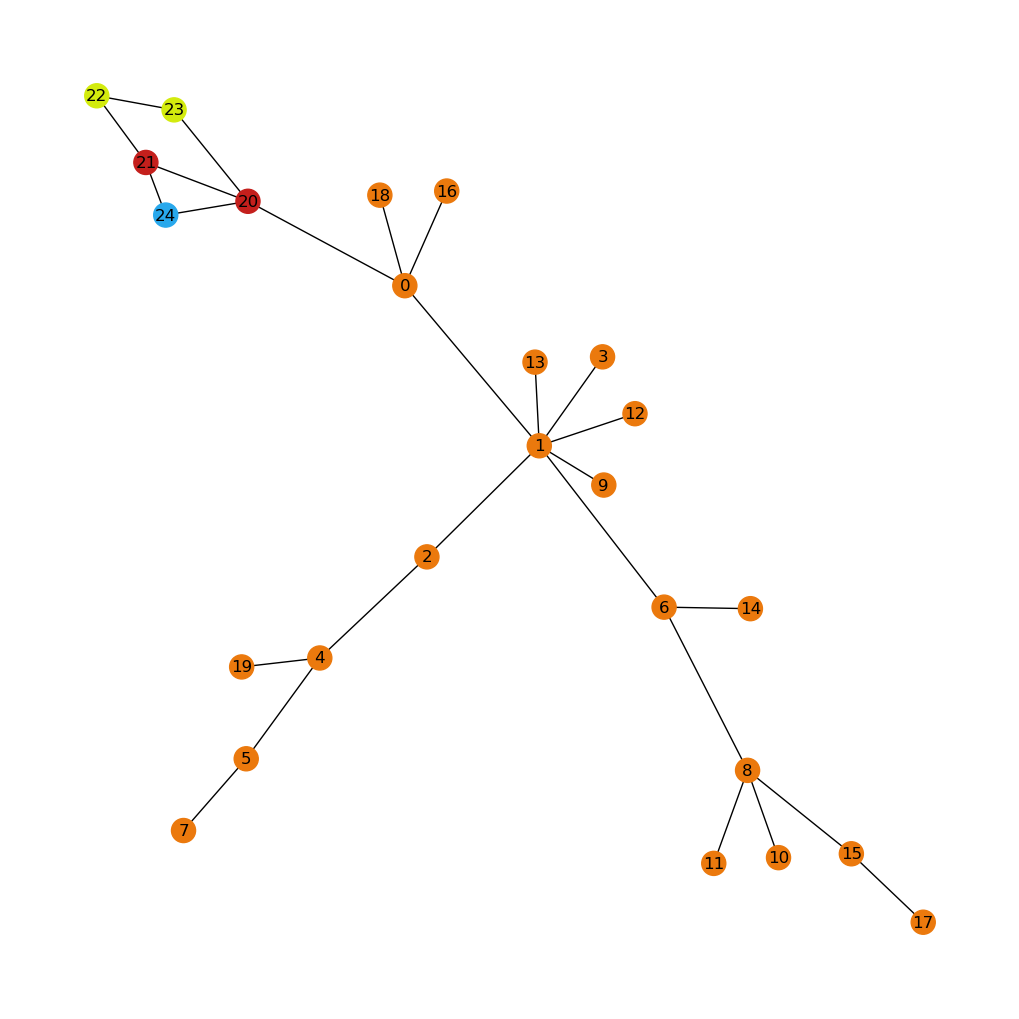

-----------------Sampled Graph-----------------


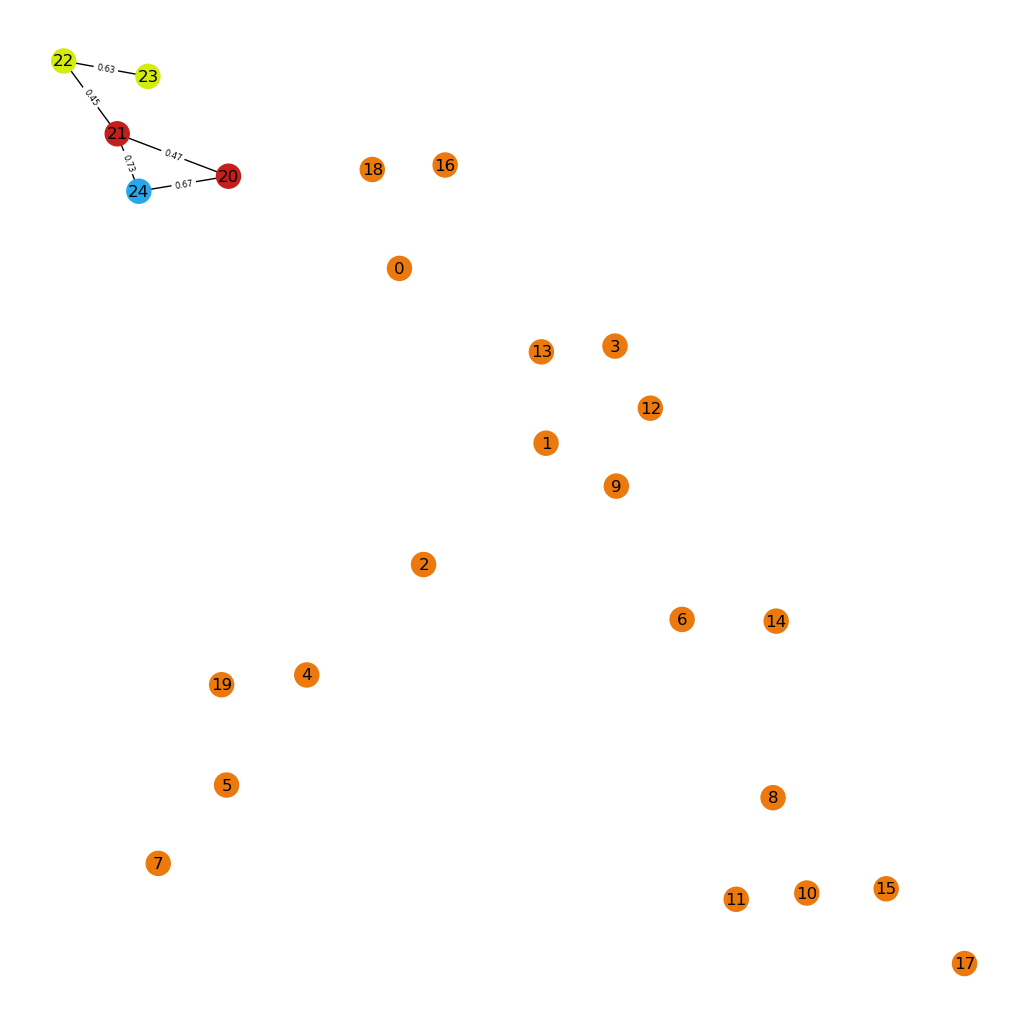

In [18]:
mlp.eval()
downstreamTask.eval()

w_ij = mlp.forward(downstreamTask, data1.x, data1.edge_index)

print(w_ij)

edge_ij = mlp.sampleGraph(w_ij)
print(edge_ij)

_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = data1.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

# edge_index_masked and weights_masked to display top 5 edges; data1.edge_index and w_ij to display original graph
Gs = Data(x=data1.x, edge_index=edge_index_masked, edge_attr=weights_masked)

#print(Gs.edge_attr)
#print(weights_masked)

print("-----------------Original Graph-----------------")

#pos = utils.plotGraph(data1, MUTAG=MUTAG)
pos = utils.plotGraphAll(data1, number_nodes=True, graph_task=True)

print("-----------------Sampled Graph-----------------")

#pos1 = utils.plotGraph(Gs, pos=pos, color_map=None, edge_weights=True, MUTAG=MUTAG)
pos1 = utils.plotGraphAll(Gs, pos=pos, number_nodes=True, graph_task=True, edge_weights=True)